<a href="https://colab.research.google.com/github/Parth-Ach2002/Image-Classification/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the necessary libraries**

In [15]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

**Connecting google drive with our file in order to access the contents of the dataset**

In [18]:
# Mounting the Data from Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

**Setting the path for all the datasets**

In [94]:
# Set path for all three datasets
train_path="/content/drive/MyDrive/Image Classification Dataset/Train"
test_path="/content/drive/MyDrive/Image Classification Dataset/Test"
val_path="/content/drive/MyDrive/Image Classification Dataset/Validation"

**Generating image data along with few transformations**

In [95]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=30, width_shift_range=10.0, height_shift_range=10.0, shear_range=10,
                                   zoom_range=0.1,
                                   vertical_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [96]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16
                                                )
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 16
                                            )

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 16

                                          )

Found 210 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


**Printing the class indices**

In [97]:
training_set.class_indices

{'No Parking': 0, 'One Way': 1, 'Zebra Crossing': 2}

**Installing Keras Tuner for hyperparameter optimization**

In [98]:
pip install keras-tuner

**Creating the model architecture**

In [99]:
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=256, step=32), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Conv2D(hp.Int('conv3_units', min_value=16, max_value=64, step=16), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense1_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(hp.Int('dense2_units', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout3', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

**Importing RandomSearch from keras.tuners library**

In [100]:
from kerastuner.tuners import RandomSearch

**Perform Hyperparameter tuning**

In [104]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuning_directory',
    project_name='my_model'
)

In [105]:
tuner.search(training_set,
             validation_data=val_set,
             epochs=30,
             batch_size=16)

Trial 5 Complete [00h 02m 22s]
val_accuracy: 0.8333333134651184

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 13m 08s


**Selecting the optimal parameters obtained through tuning**

In [106]:
best_hp = tuner.get_best_hyperparameters()[0]
final_model = build_model(best_hp)

**Fitting the model using train data and providing val_set for validation data**

In [107]:
history = final_model.fit(training_set,
                          validation_data=val_set,
                          epochs=30,
                          batch_size=16)

Epoch 1/30
14/14 [==============================] - 7s 228ms/step - loss: 1.1283 - accuracy: 0.4000 - val_loss: 1.0763 - val_accuracy: 0.3333
Epoch 2/30
14/14 [==============================] - 3s 236ms/step - loss: 1.0308 - accuracy: 0.4381 - val_loss: 1.0436 - val_accuracy: 0.3000
Epoch 3/30
14/14 [==============================] - 5s 337ms/step - loss: 1.0317 - accuracy: 0.4333 - val_loss: 1.0596 - val_accuracy: 0.4333
Epoch 4/30
14/14 [==============================] - 4s 260ms/step - loss: 0.8829 - accuracy: 0.6048 - val_loss: 1.1353 - val_accuracy: 0.3333
Epoch 5/30
14/14 [==============================] - 3s 240ms/step - loss: 1.0437 - accuracy: 0.5143 - val_loss: 0.9561 - val_accuracy: 0.6667
Epoch 6/30
14/14 [==============================] - 4s 279ms/step - loss: 0.8645 - accuracy: 0.5952 - val_loss: 0.7738 - val_accuracy: 0.7000
Epoch 7/30
14/14 [==============================] - 4s 310ms/step - loss: 0.7729 - accuracy: 0.6095 - val_loss: 0.7215 - val_accuracy: 0.6667
Epoch 

**Saving the model**

In [113]:
final_model.save('model.keras')

**Printing the accuracy of the model**

In [108]:
(loss, accuracy) = final_model.evaluate(test_set)
print(loss)
print(accuracy)

4/4 [==============================] - 1s 153ms/step - loss: 0.3096 - accuracy: 0.8833
0.30956897139549255
0.8833333253860474


**Plots**

Text(0.5, 1.0, 'Accuracy Curves')

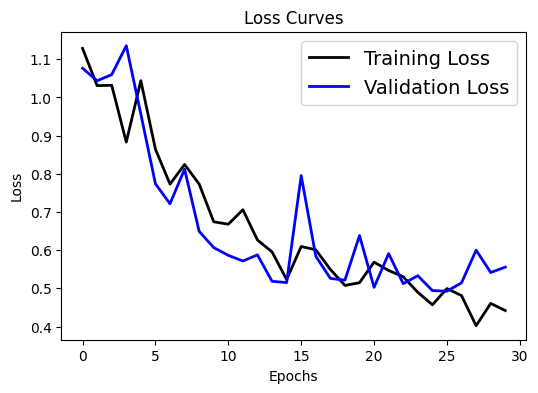

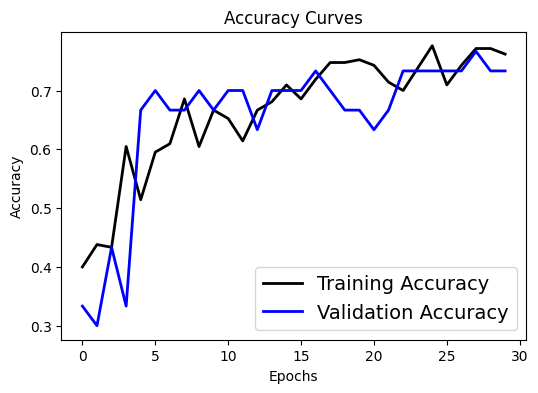

In [116]:
# Plotting the loss curve

plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# Plotting the accuracy curve

plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

**Installing the gradio library**

In [109]:
pip install gradio

1/1 [==============================] - 0s 47ms/step


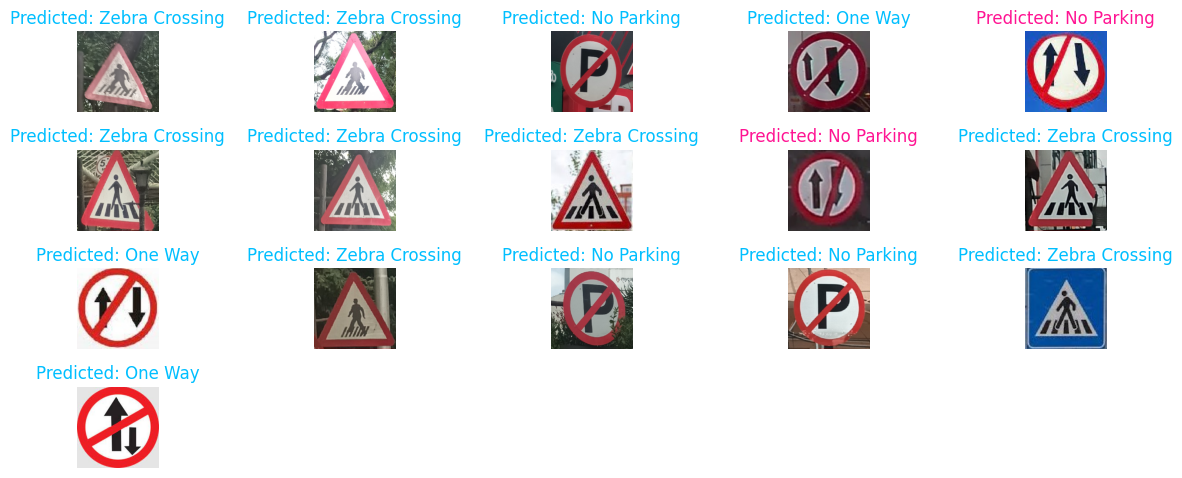

In [117]:
from tensorflow.keras.models import load_model

class_indices = training_set.class_indices
class_names = list(class_indices.keys())

batch_images, batch_labels = next(test_set)

predictions = final_model.predict(batch_images)

# Plot images with predictions
plt.figure(figsize=(12, 12))
for i in range(len(batch_images)):
    plt.subplot(10, 5, i + 1)

    # Display the image
    plt.imshow(batch_images[i])

    if np.argmax(predictions[i]) == np.argmax(batch_labels[i]):
        title_color = 'deepskyblue'
    else:
        title_color = 'deeppink'

    predicted_class = class_names[np.argmax(predictions[i])]

    plt.title(f'Predicted: {predicted_class}', color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Creating function to preprocess the input of gradio**

In [114]:
import gradio as gr
from PIL import Image
import numpy as np

def predict_image(image):
    # Preprocess the image (resize, normalize)
    image = Image.fromarray(image)
    image = image.resize((224, 224))
    image = np.array(image) / 255.0

    # Make predictions using the model
    predictions = final_model.predict(np.expand_dims(image, axis=0))
    predicted_class = class_names[np.argmax(predictions)]

    return predicted_class

**Creating the gradio Interface**

In [118]:
image_input = gr.inputs.Image(shape=(224, 224))
label_output = gr.outputs.Label()
gr.Interface(fn=predict_image, inputs=image_input, outputs=label_output).launch(share=True)

<ipython-input-118-eedc9f1d8c39>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image_input = gr.inputs.Image(shape=(224, 224))
<ipython-input-118-eedc9f1d8c39>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image_input = gr.inputs.Image(shape=(224, 224))
<ipython-input-118-eedc9f1d8c39>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label_output = gr.outputs.Label()
<ipython-input-118-eedc9f1d8c39>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label_output = gr.outputs.Label()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a1783f490fd65bd6f8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
